In [1]:
import json
import math
import random
from rastrigin import rastrigin
from sphere import sphere_function
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

fitness_function = sphere_function

numberOfIterations = 1000
numberOfAgents = 50
dimensions = 5
minRast = -5.12
maxRast = 5.12

settings = {
    "startEnergy": 100,
    "mutation_probability": 0.5,
    "mutation_element_probability": 0.2,
    "crossover_probability": 0.5,
    "distribution_index": 0.2,
    "fightLossEnergy": 0.05,
    "reproduceLossEnergy": 0.25,
    "fightReqEnergy": 0,
    "reproduceReqEnergy": 150
}

pandas_data_agents = {
    "nr": [],
    "x": [],
    "start_energy": [],
    "fitness": []
}

pandas_data = {
    "iter": [],
    "number_of_agents": [],
    "born_agents": [],
    "dead_agents": [],
    "best_agent_fitness": [],
    "average_fitness": [],
    "best_agent_energy": [],
    "average_energy": [],
    "min_std_dev": [],
    "max_std_dev": [],
    "lowest_energy": [],
    "sum_energy": []
}


pandas_data_agents_energy = dict()
pandas_data_dead_agents_energy = []


def add_agent_to_pd_energy(agent):
    if len(pandas_data_agents_energy) == 0:
        pandas_data_agents_energy.append([agent.energy])
    else:
        next_idx = len(pandas_data_agents_energy)
        pandas_data_agents_energy.append([ 0 for agent_idx in range(len(pandas_data_agents_energy[next_idx-1])-1)])
        pandas_data_agents_energy[next_idx].append(agent.energy)
        

In [2]:
class Agent:
    def __init__(self, x, energy=settings["startEnergy"], iterr = 0):
        self.x = x
        self.energy = energy
        self.fitness = fitness_function(x)
        self.energy_history = [(iterr, energy)]

    @staticmethod
    def crossover(parent1, parent2):
        parents = [parent1, parent2]
        offspring = copy.deepcopy(parents)
        permutation_length = len(offspring[0].x)

        cross_points = sorted([random.randint(0, permutation_length) for _ in range(2)])

        def _repeated(element, collection):
            c = 0
            for e in collection:
                if e == element:
                    c += 1
            return c > 1

        def _swap(data_a, data_b, cross_points):
            c1, c2 = cross_points
            new_a = data_a[:c1] + data_b[c1:c2] + data_a[c2:]
            new_b = data_b[:c1] + data_a[c1:c2] + data_b[c2:]
            return new_a, new_b

        def _map(swapped, cross_points):
            n = len(swapped[0])
            c1, c2 = cross_points
            s1, s2 = swapped
            map_ = s1[c1:c2], s2[c1:c2]
            for i_chromosome in range(n):
                if not c1 < i_chromosome < c2:
                    for i_son in range(2):
                        while _repeated(swapped[i_son][i_chromosome], swapped[i_son]):
                            try:
                                map_index = map_[i_son].index(swapped[i_son][i_chromosome])
                                swapped[i_son][i_chromosome] = map_[1 - i_son][map_index]
                            except ValueError as ve:
                                print('ValueError encountered, Action skipped')
                                break
            return s1, s2

        swapped = _swap(parents[0].x, parents[1].x, cross_points)
        mapped = _map(swapped, cross_points)

        offspring[0].x, offspring[1].x = mapped

        return offspring[0].x, offspring[1].x
    
    def add_energy_to_history(self, iterr):
        self.energy_history.append((iterr, self.energy))
    
    @staticmethod
    def mutate(x):
        for i in range(len(x)):
            rand = random.random()

            if rand <= 1 / len(x):
                y = x[i]
                yl, yu = minRast, maxRast

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (settings["distribution_index"] + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < minRast:
                        y = minRast
                    if y > maxRast:
                        y = maxRast
                x[i] = y
        return x

    @staticmethod
    def reproduce(parent1, parent2, loss_energy, f_avg, iterr):
        parent1_loss = math.ceil(parent1.energy * loss_energy)
        parent1.energy -= parent1_loss

        parent2_loss = math.ceil(parent2.energy * loss_energy)
        parent2.energy -= parent2_loss

        # Possible crossover
        if random.random() < settings["crossover_probability"]:
            newborns = Agent.crossover(parent1, parent2)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]
        else:
            newborns = Agent.crossover(parent2, parent1)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]

        mutation_probability_x1 = mutation_probability_x2 = settings["mutation_probability"]

        if fitness_function(newborn_x1) < f_avg:
            mutation_probability_x1 /= 2
        else:
            mutation_probability_x1 *= 2

        if fitness_function(newborn_x2) < f_avg:
            mutation_probability_x2 /= 2
        else:
            mutation_probability_x2 *= 2

        random_number = random.random()
        if random_number < mutation_probability_x1:
            newborn_x1 = Agent.mutate(newborn_x1)
        if random_number < mutation_probability_x2:
            newborn_x2 = Agent.mutate(newborn_x2)

        newborn1 = Agent(newborn_x1, parent1_loss + parent2_loss, iterr)
        newborn2 = Agent(newborn_x2, parent1_loss + parent2_loss, iterr)
        
        if newborn1.fitness < newborn2.fitness:
            pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
            pandas_data_agents["x"].append(newborn1.x)
            pandas_data_agents["start_energy"].append(newborn1.energy)
            pandas_data_agents["fitness"].append(newborn1.fitness)
#             add_agent_to_pd_energy(newborn1)
            return newborn1
        else:
            pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
            pandas_data_agents["x"].append(newborn2.x)
            pandas_data_agents["start_energy"].append(newborn2.energy)
            pandas_data_agents["fitness"].append(newborn2.fitness)
#             add_agent_to_pd_energy(newborn2)
            return newborn2

    @staticmethod
    def fight(agent_1, agent_2, loss_energy):
        if agent_1.fitness < agent_2.fitness:
            energy = agent_2.energy * loss_energy
            agent_1.energy += energy
            agent_2.energy -= energy
        else:
            energy = agent_1.energy * loss_energy
            agent_1.energy -= energy
            agent_2.energy += energy

        agent_1.energy = np.true_divide(np.floor(agent_1.energy * 10**8), 10**8)
        agent_2.energy = np.true_divide(np.floor(agent_2.energy * 10**8), 10**8)

    

    # @staticmethod
    # def fight(agent_1, agent_2, loss_energy):
    #     if agent_1.fitness < agent_2.fitness:
    #         energy = agent_2.energy
    #         agent_1.energy += energy
    #         agent_2.energy -= energy
    #     else:
    #         energy = agent_1.energy
    #         agent_1.energy -= energy
    #         agent_2.energy += energy

    def is_dead(self):
        return self.energy <= 0
    

In [3]:
class EMAS:
    def __init__(self, agents):
        self.agents = agents
        self.iteration = 0

    def run_iteration(self):
        random.shuffle(self.agents)

        children = self.reproduce()
        self.fight()
        for agent in self.agents:
            agent.add_energy_to_history(self.iteration)

        self.agents.extend(children)
#         for idx, agent in enumerate(self.agents):
#             pandas_data_agents_energy[idx].append(agent.energy)
        dead = self.clear()
        self.iteration += 1
        
        return len(children), len(dead)

    def reproduce(self):
        req_energy = settings["reproduceReqEnergy"]
        loss_energy = settings["reproduceLossEnergy"]

        parents = []
        children = []
        for idx, parent1 in enumerate(self.agents):
            if parent1.energy > req_energy and parent1 not in parents:
                available_parents = [agent for agent in self.agents if
                                     agent != parent1 and agent.energy > req_energy and agent not in parents]
                if available_parents:
                    parent2 = random.choice(available_parents)
                    children.append(Agent.reproduce(parent1, parent2, loss_energy,
                                                    np.average([agent.fitness for agent in self.agents]), self.iteration))
                    parents.extend([parent1, parent2])

        return children

    def fight(self):
        req_energy = settings["fightReqEnergy"]
        loss_energy = settings["fightLossEnergy"]

        fighters = []
        for idx, agent1 in enumerate(self.agents):
            if agent1.energy > req_energy and agent1 not in fighters:
                available_fighters = [agent for agent in self.agents if
                                      agent != agent1 and agent.energy > req_energy and agent not in fighters]
                if available_fighters:
                    agent2 = random.choice(available_fighters)
                    Agent.fight(agent1, agent2, loss_energy)
                    fighters.extend([agent1, agent2])

    def clear(self):
        dead = []
        for idx, agent in enumerate(self.agents):
            if agent.is_dead():
                dead.append(agent)
                
                next_item = len(pandas_data_dead_agents_energy)
                pandas_data_dead_agents_energy.append([])
                first_iter, first_energy = agent.energy_history[0]
                for i in range(first_iter):
                    pandas_data_dead_agents_energy[next_item].append(0)
                for a in agent.energy_history:
                    pandas_data_dead_agents_energy[next_item].append(a[1])
        
        self.agents = [agent for agent in self.agents if not agent.is_dead()]
        return dead

In [4]:
def generate_agents():
    gen_agents = [Agent([random.uniform(minRast, maxRast) for _ in range(dimensions)]) for _ in range(numberOfAgents)]
    
    for agent in gen_agents:
#         add_agent_to_pd_energy(agent)
        pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
        pandas_data_agents["x"].append(agent.x)
        pandas_data_agents["start_energy"].append(agent.energy)
        pandas_data_agents["fitness"].append(agent.fitness)
        
    return gen_agents


def save_to_file(output):
    settings['function'] = fitness_function.__name__
    settings['output'] = output
    try:
        with open("results.txt", 'a+') as file:
            json.dump(settings, file, indent=4)
            file.write('\n')
    except Exception as e:
        print("Error while saving results to file:", e)


In [5]:

def main():
    agents = generate_agents()

    emas = EMAS(agents)

    total_number_of_born, total_number_of_dead = 0, 0
    data = []
    for it in range(numberOfIterations):
        # Number of agents, born agents and dead agents
        born_num, dead_num = emas.run_iteration()
        total_number_of_born += born_num
        total_number_of_dead += dead_num
        agents_num = len(emas.agents)
        energy_sum = np.sum([agent.energy for agent in emas.agents])

        if it%10 == 0:
            print(it, agents_num)


        # Min and Max standard deviations along each dimension for agents
        vectors = np.array([agent.x for agent in emas.agents])
        std = np.std(vectors, axis=0)
        min_std = min(std)
        max_std = max(std)

        # Best agent based on its fitness
        best_agent = min(emas.agents, key=lambda agent: agent.fitness)
        lowest_energy = min(emas.agents, key=lambda agent: agent.energy).energy
        # print(it, agents_num)
        
        fitness_avg = np.average([agent.fitness for agent in emas.agents])
        energy_avg = np.average([agent.energy for agent in emas.agents])
        
        # Add data
        data.append((
            agents_num,
            born_num,
            dead_num,
            best_agent.fitness,
            fitness_avg,
            best_agent.energy,
            energy_avg,
            min_std,
            max_std,
            energy_sum
        ))
        
        # Add data to dataFrame
        pandas_data["iter"].append(it)
        pandas_data["number_of_agents"].append(agents_num)
        pandas_data["born_agents"].append(born_num)
        pandas_data["dead_agents"].append(dead_num)
        pandas_data["best_agent_fitness"].append(best_agent.fitness)
        pandas_data["average_fitness"].append(fitness_avg)
        pandas_data["best_agent_energy"].append(best_agent.energy)
        pandas_data["average_energy"].append(energy_avg)
        pandas_data["min_std_dev"].append(min_std)
        pandas_data["max_std_dev"].append(max_std)
        pandas_data["lowest_energy"].append(lowest_energy)
        pandas_data["sum_energy"].append(energy_sum)
        
#         if it%50 == 0:
#             print(f'\n\n')
#             for item in data:
#                 print(item)
#             print(f"\n{it}")
#             print(f"Lowest energy: {lowest_energy}")
#             print(len(emas.agents),[agent.energy for agent in emas.agents])
#             input()

    print("Number of agents left:", len(emas.agents))
    print()
    print("Total number of born agents:", total_number_of_born)
    print("Total number of dead agents:", total_number_of_dead)
    print()

    best_agent = min(emas.agents, key=lambda agent: agent.fitness)

    for i in range(len(best_agent.x)):
        best_agent.x[i] = round(best_agent.x[i], 2)

    output = f"Minimum in {best_agent.x} equals = {best_agent.fitness:.2f} for agent with energy equals = {best_agent.energy:.2f}"
    print(output)
    
    # fill pandas data energy
    for idx, agent in enumerate(emas.agents):
        next_item = len(pandas_data_dead_agents_energy)
        pandas_data_dead_agents_energy.append([])
        first_iter, first_energy = agent.energy_history[0]
        for i in range(first_iter):
            pandas_data_dead_agents_energy[next_item].append(0)
        for a in agent.energy_history:
            pandas_data_dead_agents_energy[next_item].append(a[1])
    
    for idx, agent in enumerate(pandas_data_dead_agents_energy):
        if len(agent) != emas.iteration:
            diff = emas.iteration - len(agent)
            for iterrr in range(diff):
                agent.append(0)
        if len(agent) > emas.iteration:
            diff = len(agent) - emas.iteration
            agent = agent[:-diff]
        pandas_data_agents_energy[str(idx)] = agent
    pandas_data_agents_energy['iter'] = [ i for i in range(emas.iteration)]
    
#     df_agents_energy = pd.DataFrame(pandas_data_agents_energy) 
#     df_agents = pd.DataFrame(pandas_data) 
#     display(df_agents_energy)
#     display(df_agents)
        

#     iteration_data = list(range(len(data)))
#     number_of_agents = [item[0] for item in data]
#     number_of_born_agents = [item[1] for item in data]
#     number_of_dead_agents = [item[2] for item in data]
#     best_fitness = [item[3] for item in data]
#     avg_fitness = [item[4] for item in data]
#     best_energy = [item[5] for item in data]
#     avg_energy = [item[6] for item in data]
#     min_std = [item[7] for item in data]
#     max_std = [item[8] for item in data]
#     sum_energy = [item[9] for item in data]

#     fig, ax = plt.subplots(5, 2)
#     fig.set_figheight(30)
#     fig.set_figwidth(20)

#     ax[0, 0].plot(iteration_data, number_of_agents, marker='o', linestyle='-')
#     ax[0, 0].set_title("Number of agents after each iterations")
#     ax[0, 0].set_xlabel("Iteration")
#     ax[0, 0].set_ylabel("Number of agents")
#     ax[0, 0].grid()

#     ax[0, 1].plot(iteration_data, sum_energy, marker='o', linestyle='-')
#     ax[0, 1].set_title("Energy sum")
#     ax[0, 1].set_xlabel("Iteration")
#     ax[0, 1].set_ylabel("Energy sum")
#     ax[0, 1].grid()

#     ax[1, 0].plot(iteration_data, number_of_born_agents, marker='o', linestyle='-')
#     ax[1, 0].set_title("Number of born agents after each iteration")
#     ax[1, 0].set_xlabel("Iteration")
#     ax[1, 0].set_ylabel("Born")
#     ax[1, 0].grid()

#     ax[1, 1].plot(iteration_data, number_of_dead_agents, marker='o', linestyle='-')
#     ax[1, 1].set_title("Number of dead agents after each iteration")
#     ax[1, 1].set_xlabel("Iteration")
#     ax[1, 1].set_ylabel("Dead")
#     ax[1, 1].grid()

#     ax[2, 0].plot(iteration_data, best_fitness, marker='o', linestyle='-')
#     ax[2, 0].set_title("Best fitness after each iteration")
#     ax[2, 0].set_xlabel("Iteration")
#     ax[2, 0].set_ylabel("Best fitness")
#     ax[2, 0].grid()

#     ax[2, 1].plot(iteration_data, avg_fitness, marker='o', linestyle='-')
#     ax[2, 1].set_title("Average fitness after each iteration")
#     ax[2, 1].set_xlabel("Iteration")
#     ax[2, 1].set_ylabel("Avg fitness")
#     ax[2, 1].grid()

#     ax[3, 0].plot(iteration_data, best_energy, marker='o', linestyle='-')
#     ax[3, 0].set_title("Best energy after each iteration")
#     ax[3, 0].set_xlabel("Iteration")
#     ax[3, 0].set_ylabel("Best energy")
#     ax[3, 0].grid()

#     ax[3, 1].plot(iteration_data, avg_energy, marker='o', linestyle='-')
#     ax[3, 1].set_title("Average energy after each iteration")
#     ax[3, 1].set_xlabel("Iteration")
#     ax[3, 1].set_ylabel("Avg energy")
#     ax[3, 1].grid()

#     ax[4, 0].plot(iteration_data, min_std, marker='o', linestyle='-')
#     ax[4, 0].set_title("Min standard deviation after each iteration")
#     ax[4, 0].set_xlabel("Iteration")
#     ax[4, 0].set_ylabel("min std")
#     ax[4, 0].grid()

#     ax[4, 1].plot(iteration_data, max_std, marker='o', linestyle='-')
#     ax[4, 1].set_title("Max standard deviation after each iteration")
#     ax[4, 1].set_xlabel("Iteration")
#     ax[4, 1].set_ylabel("max std")
#     ax[4, 1].grid()

#     plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
#     fig.suptitle(fitness_function.__name__ + ' minimization', fontsize=14)
#     plt.show()

#     save_to_file(output)


main()

0 50
10 51
20 56
30 59
40 63
50 66
60 69
70 75
80 76
90 79
100 81
110 84
120 88
130 90
140 93
150 94
160 96
170 99
180 101
190 103
200 105
210 107
220 109
230 111
240 113
250 115
260 115
270 119
280 121
290 125
300 125
310 127
320 127
330 129
340 132
350 134
360 136
370 137
380 139
390 140
400 140
410 142
420 139
430 141
440 141
450 142
460 143
470 142
480 142
490 142
500 143
510 143
520 145
530 143
540 142
550 143
560 143
570 141
580 143
590 143
600 143
610 144
620 142
630 142
640 144
650 143
660 144
670 144
680 145
690 146
700 148
710 149
720 148
730 150
740 152
750 152
760 153
770 155
780 157
790 159
800 160
810 161
820 162
830 164
840 166
850 167
860 168
870 170
880 171
890 173
900 173
910 175
920 175
930 176
940 177
950 178
960 179
970 180
980 181
990 180
Number of agents left: 180

Total number of born agents: 179
Total number of dead agents: 49

Minimum in [-0.19, 0.0, -1.1, -0.26, -0.42] equals = 1.50 for agent with energy equals = 130.19


In [6]:
    df_agents = pd.DataFrame(pandas_data) 
    display(df_agents)

,iter,number_of_agents,born_agents,dead_agents,best_agent_fitness,average_fitness,best_agent_energy,average_energy,min_std_dev,max_std_dev,lowest_energy,sum_energy
0,0,50,0,0,9.589665,45.014263,105.000000,100.000000,2.786834,3.159205,9.500000e+01,5000.000000
1,1,50,0,0,9.589665,45.014263,109.750000,100.000000,2.786834,3.159205,9.025000e+01,5000.000000
2,2,50,0,0,9.589665,45.014263,114.762500,100.000000,2.786834,3.159205,8.573750e+01,5000.000000
3,3,50,0,0,9.589665,45.014263,119.049375,100.000000,2.786834,3.159205,8.145063e+01,5000.000000
4,4,50,0,0,9.589665,45.014263,123.121906,100.000000,2.786834,3.159205,7.737809e+01,5000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,180,1,1,1.497616,6.124086,123.709712,27.777774,0.653142,1.031235,1.100000e-07,4999.999366
996,996,180,0,0,1.497616,6.124086,130.184231,27.777774,0.653142,1.031235,1.000000e-07,4999.999365
997,997,180,0,0,1.497616,6.124086,130.184258,27.777774,0.653142,1.031235,9.000000e-08,4999.999364
998,998,180,0,0,1.497616,6.124086,130.184340,27.777774,0.653142,1.031235,8.000000e-08,4999.999363


<Axes: xlabel='iter'>

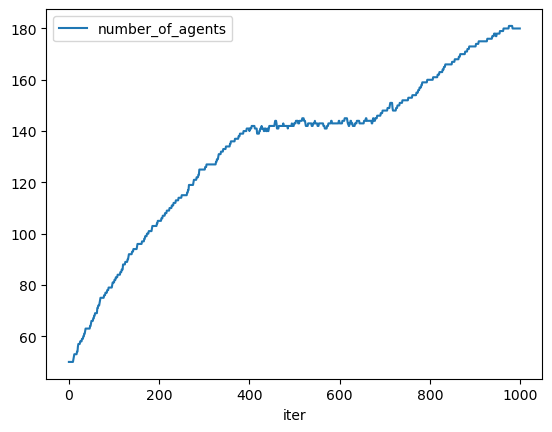

In [7]:
df_agents.plot(x="iter", y="number_of_agents")

<Axes: xlabel='iter'>

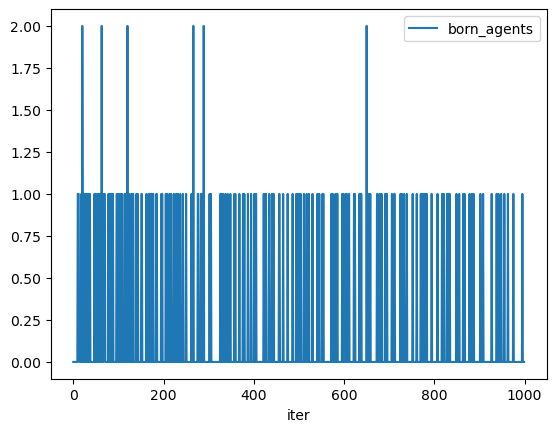

In [8]:
df_agents.plot(x="iter", y="born_agents")

<Axes: xlabel='iter'>

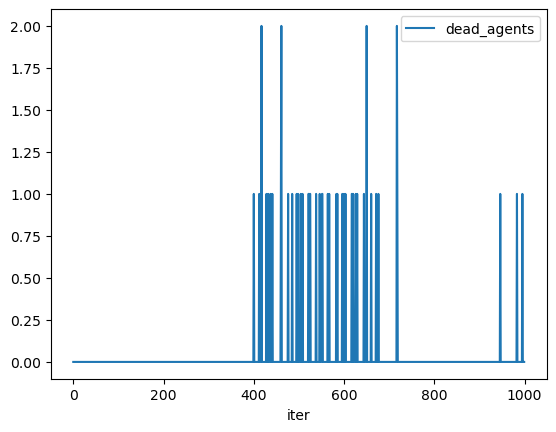

In [9]:
df_agents.plot(x="iter", y="dead_agents")

<Axes: xlabel='iter'>

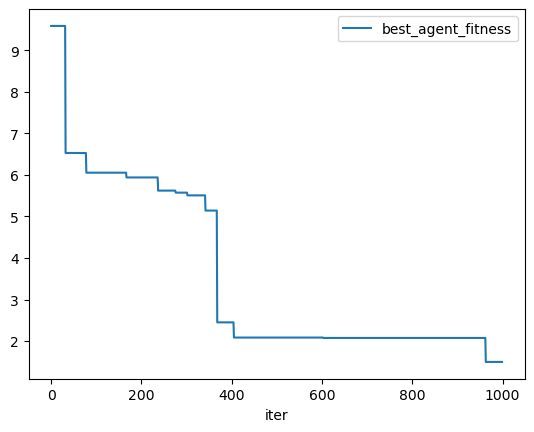

In [10]:
df_agents.plot(x="iter", y="best_agent_fitness")

<Axes: xlabel='iter'>

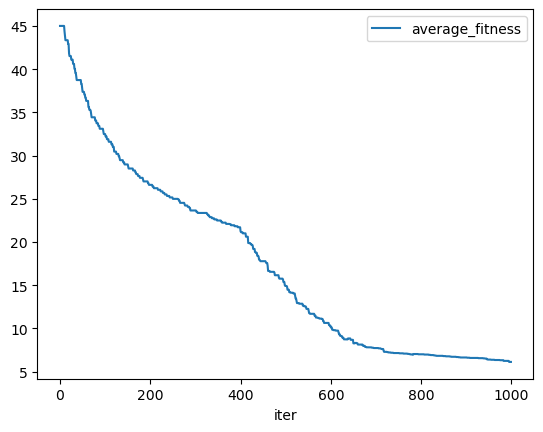

In [11]:
df_agents.plot(x="iter", y="average_fitness")

<Axes: xlabel='iter'>

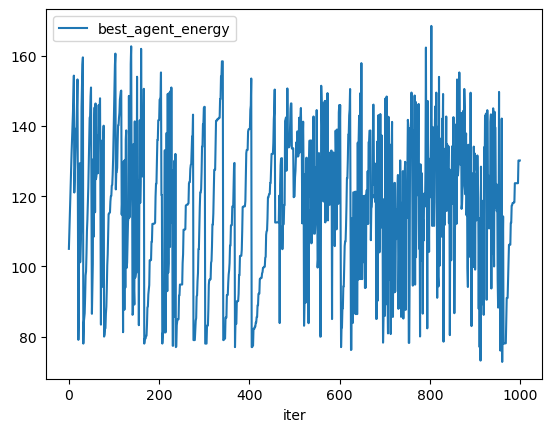

In [12]:
df_agents.plot(x="iter", y="best_agent_energy")

<Axes: xlabel='iter'>

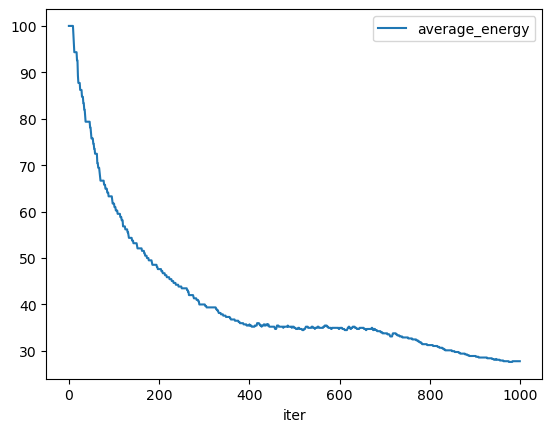

In [13]:
df_agents.plot(x="iter", y="average_energy")

<Axes: xlabel='iter'>

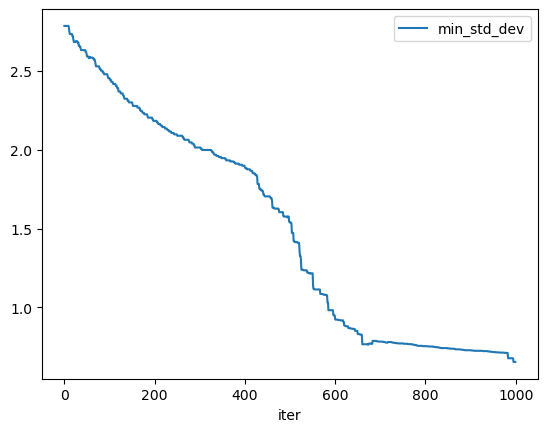

In [14]:
df_agents.plot(x="iter", y="min_std_dev")

<Axes: xlabel='iter'>

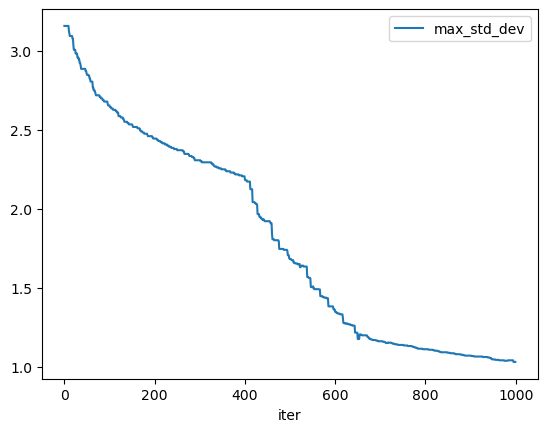

In [15]:
df_agents.plot(x="iter", y="max_std_dev")

In [16]:
df_agents_energy = pd.DataFrame(pandas_data_agents_energy) 
display(df_agents_energy)

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,iter
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,105.000000,95.000000,95.000000,95.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,99.750000,90.250000,100.250000,90.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,85.737500,85.737500,85.737500,85.737500,85.737500,85.737500,94.762500,85.737500,95.237500,94.762500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
4,81.450625,81.450625,81.450625,81.450625,81.450625,81.450625,90.024375,81.450625,90.475625,90.024375,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,27.566934,4.142835,0.000971,96.398036,0.219981,10.258047,25.638886,0.001857,0.000070,995
996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,27.581500,4.231133,0.000923,96.398471,0.208982,9.745145,24.356941,0.001968,0.000067,996
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,26.202425,4.019577,0.000876,91.578548,0.198533,9.788820,24.368367,0.001869,0.000063,997
998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,26.203459,4.020828,0.000833,91.578561,0.188606,9.788838,23.149948,0.001776,0.000060,998


<Axes: xlabel='iter'>

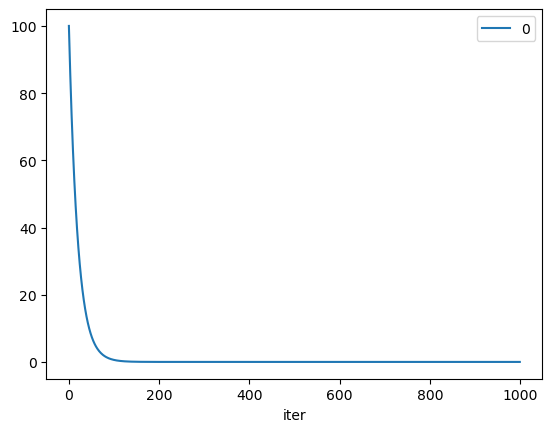

In [17]:
df_agents_energy.plot(x='iter', y="0")

<Axes: xlabel='iter'>

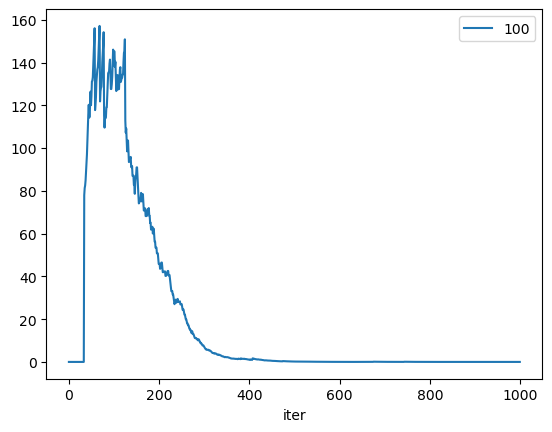

In [18]:
df_agents_energy.plot(x='iter', y="100")

In [19]:
df_agents_energy.plot(x='iter', y="300")

KeyError: '300'

In [ ]:
df_agents_energy.plot(x='iter', y="500")

In [ ]:
df_agents_energy.plot(x='iter', y="700")

In [ ]:
df_agents_energy.plot(x='iter', y="900")